## Standard Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import nltk

If you're new to NLTK make sure to run below cell and download **stopwords**

In [3]:
# nltk.download_shell()

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [5]:
sms = pd.read_csv("./smsspamcollection/SMSSpamCollection",sep='\t',names=['label','message'])

In [6]:
sms = sms[['message','label']]
sms.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


## Explolatory Data Analysis

<AxesSubplot:xlabel='label', ylabel='count'>

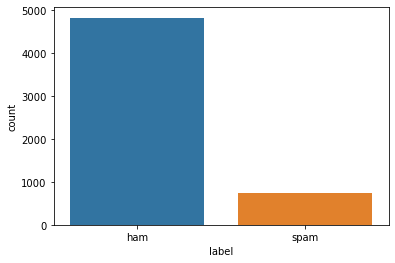

In [8]:
sns.countplot(x = 'label',data = sms)

In [8]:
sms.describe()

,message,label
count,5572,5572
unique,5169,2
top,"Sorry, I'll call later",ham
freq,30,4825


In [9]:
labels = sms.groupby(by='label')

In [10]:
labels.describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Defining the data using length of messages

In [11]:
sms['length'] = sms['message'].apply(len)

In [12]:
labels.describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

In [13]:
sms.head()

,message,label,length
0,"Go until jurong point, crazy.. Available only ...",ham,111
1,Ok lar... Joking wif u oni...,ham,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155
3,U dun say so early hor... U c already then say...,ham,49
4,"Nah I don't think he goes to usf, he lives aro...",ham,61


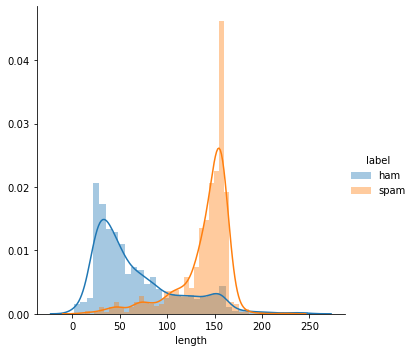

In [14]:
g = sns.FacetGrid(sms[sms['length'] <=250],size=5,hue='label')
g.map(sns.distplot,'length')
g.add_legend()

From this we can conclude that **Spam messages tend to be longer than Non-Spam messages**

## Data Cleaning

In [15]:
import string
from nltk.corpus import stopwords

In [16]:
def text_cleaning(text):
    nopunc_text = "".join([i for i in text if i not in string.punctuation])
    new_text = [i for i in nopunc_text.split() if i.lower() not in stopwords.words('english')]
    return new_text

In [17]:
sms['message'].head(5).apply(text_cleaning)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

## Feature Vectorization

## Count Vectorizer

What Count Vectorizer does is that based on a vocabulary, it returns a 2D matrix of NxM where N is the number of sentences passed and M is the number of words in the vocabulary. 

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

Picking up a random message to demonstrate

In [19]:
message21 = sms['message'][21]
print(message21)

I‘m going to try for 2 months ha ha only joking


In [20]:
bow_transformer = CountVectorizer(analyzer=text_cleaning).fit(sms['message'])

In [21]:
print(len(bow_transformer.vocabulary_))

11425


We have 11425 unique words

In [22]:
bow21 = bow_transformer.transform([message21])
print(bow21)
print(bow21.shape)

  (0, 423)	1
  (0, 2401)	1
  (0, 6882)	1
  (0, 6992)	2
  (0, 7534)	1
  (0, 8251)	1
  (0, 10655)	1
(1, 11425)


Since we passed only one sentence, we got a 1X11425 matrix. Since it's a sparse matrix most of the entries are zero and we only got those enties which were non-zero

Here the first element of the tuple is the index of the sentence and the second element of specifies the index of the word in the bag of words and on the right, we have word frequencies<br>
Let's check some of these out 

In [23]:
print(bow_transformer.get_feature_names()[6992])
print(bow_transformer.get_feature_names()[423])

ha
2


In [24]:
messages_bow = bow_transformer.transform(sms['message'])

In [25]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


We can see that we have 5572 messages having 11425 columns

In [26]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.07940295412668218


## TF-IDF Vectorizer

Term Frequency is the frequency of a word in a specific document<br>
Inverse Document Frequency is the log of total documents divided by the documents which contain the that word

<img src = "./1_V9ac4hLVyms79jl65Ym_Bw.jpeg" height = "1000px" width = "500px">

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [28]:
tfidf21 = tfidf_transformer.transform(bow21)
print(tfidf21)

  (0, 10655)	0.26267609466103015
  (0, 8251)	0.3223413452328098
  (0, 7534)	0.35363063404108536
  (0, 6992)	0.7072612680821707
  (0, 6882)	0.20923964496217218
  (0, 2401)	0.36186079353173206
  (0, 423)	0.16461997711797113


In [29]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


In [30]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


Since the messages are independent of each other we'll be using using Naive Bayes Classifier

In [31]:
from sklearn.naive_bayes import MultinomialNB

## Train Test Split

In [32]:
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(sms['message'], sms['label'], test_size=0.25)

## Creating the Pipeline

A machine learning pipeline is used to help automate machine learning workflows. They operate by enabling a sequence of data to be transformed and correlated together in a model that can be tested and evaluated to achieve an outcome, whether positive or negative

In [33]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_cleaning)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [34]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_cleaning at 0x000002A5073A1DC0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [35]:
predictions = pipeline.predict(msg_test)

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1264
        spam       0.72      1.00      0.84       129

    accuracy                           0.96      1393
   macro avg       0.86      0.98      0.91      1393
weighted avg       0.97      0.96      0.97      1393



In [38]:
conf = pd.crosstab(label_test,predictions,rownames=['Actual'],colnames=['Predicted'])

In [39]:
conf

Predicted,ham,spam
Actual,,
ham,1214,0
spam,50,129


We can see that since we have less amount of Spam data our accuracy is not that good in classifying a message as Spam